In [32]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import flopy, pyproj, pandas, geopandas, shapely
import matplotlib.pyplot as plt
import matplotlib as mpl
from adjustText import adjust_text # for repelling each text
import cmcrameri
import sys

from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from shapely.geometry import LineString, Point
from flopy.discretization import VertexGrid
from flopy.utils import Raster
from flopyUtils.utils import wrap_gmsh
from flopyUtils.geometry import ModelIntersect
import flopyUtils
import datetime
print("init path:", sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
init path: ['d:\\flopy', 'c:\\ProgramData\\Anaconda3\\python38.zip', 'c:\\ProgramData\\Anaconda3\\DLLs', 'c:\\ProgramData\\Anaconda3\\lib', 'c:\\ProgramData\\Anaconda3', '', 'C:\\Users\\SUHHO LEE\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\users\\suhho lee\\desktop\\code\\flopy-utils', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\flopy-3.7.0.dev0-py3.8.egg', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\fonttools-4.49.0-py3.8.egg', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib', 'c:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin']


# Check model domain

EPSG:5186
EPSG:5186


C:\Users\SUHHO LEE\AppData\Local\Temp\ipykernel_21760\900393086.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(np.array(ax.get_xticks())/1000)
C:\Users\SUHHO LEE\AppData\Local\Temp\ipykernel_21760\900393086.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.array(ax.get_yticks())/1000)


Text(131.48889664978407, 0.5, 'y (km)')

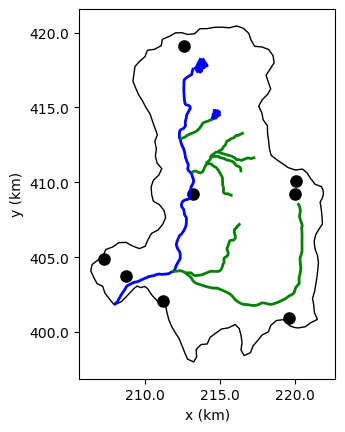

In [33]:
# Load domain
domain = geopandas.read_file('./Noseong/Data/Model_domain_polys.shp').to_crs(5186)
print(domain.crs)
# Load stream lines
stream = geopandas.read_file('./Noseong/Data/stream_1_arcs.shp').to_crs(5186)
print(stream.crs)
# Load tributaries lines
tributary = geopandas.read_file('./Noseong/Data/stream_drained_arcs.shp').to_crs(5186)
# Load well points
points = pandas.read_csv('./Noseong/Data/Observation_well.csv')
# Load lake
lake_1 = geopandas.read_file('./Noseong/Data/lake_1_polys.shp').to_crs(5186) #계룡
lake_2 = geopandas.read_file('./Noseong/Data/lake_2_polys.shp').to_crs(5186) #양화
# Draw figure
fig, ax = plt.subplots()
domain.plot(ax=ax,facecolor='none')
stream.plot(ax=ax,edgecolor='b',lw=2)
tributary.plot(ax=ax,edgecolor='g',lw=2)
ax.scatter(points['X'], points['Y'], 50, marker='o', color='k', label='Observation well', lw=2)
lake_1.plot(ax=ax,facecolor='b', label='계룡')
lake_2.plot(ax=ax,facecolor='b')
#ax.scatter(points['x'], points['y'], 50, marker='+', color='r', label='GW obs.', lw=2)
ax.plot([],[], color='k',lw=2, label='domain') # dummy plot for model domain
ax.plot([],[], color='b',lw=2, label='Noseong stream') # dummy plot for stream boundary
ax.plot([],[], color='g', lw=2, label='Tributary') # dummy plot for stream boundary
ax.set_xticklabels(np.array(ax.get_xticks())/1000)
ax.set_yticklabels(np.array(ax.get_yticks())/1000)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
#ax.legend(loc='upper right')
#fig.tight_layout()

# Make mesh using Gmsh modules

In [46]:
mesh = wrap_gmsh.Gmsh()
# Add observation points for refinement
mesh.add_point(np.vstack((points['X'], points['Y'])).T, 5)
# Add stream
'''
for geom in stream.geometry:
    if geom is not None:
        mesh.add_line(geom,100)
'''
geom = domain.geometry[0]
domain_xy = np.vstack((geom.exterior.xy[0], geom.exterior.xy[1])).T

if 1:
    tmp = mesh.generate_gmsh(domain_xy, clmax=2000, verbose=1, use_internal=1)
else:
    print('Read mesh')
    mesh.readgmsh('./temp.msh', verbose=1)
print(mesh)
tri = mesh.to_flopy_triangle()


add outer polygon.
add outer lines.
add line loop
add surface!
write geo file.
generate mesh!
   use internal mesh generation.
write mesh

gmsh infromation 
x     : 4756
y     : 4756
numberofvertices : 4756
numberofelements : 9320
numberofedges: 14075



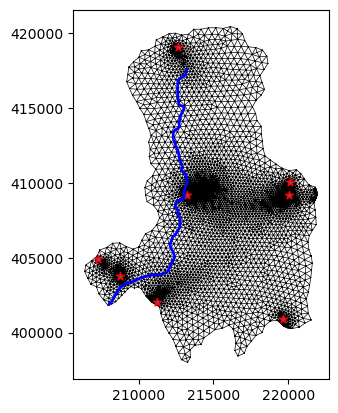

In [41]:
_xy = np.array(mesh._polygons[0])

#matplotlib widget
fig, ax = plt.subplots()
mesh.plot(ax=ax, lw=.5, color='k')
stream.plot(ax=ax, edgecolor='b', lw=2)
#ax.scatter(_xy[:,0], _xy[:,1], marker='+', edgecolor='r')
ax.scatter(points['X'],points['Y'],marker='*',edgecolor='r')

# Make voronoi grid

In [42]:
vor = VoronoiGrid(tri)
gridprops = vor.get_gridprops_vertexgrid()
voronoi_grid = VertexGrid(**gridprops, nlay=1,
                         crs=5186)

print(f'   epsg: {voronoi_grid.epsg}')
print(vor.iverts[0])
print(vor.iverts[1])
print(vor.verts[1])
print(len(voronoi_grid.verts))
print(len(voronoi_grid.iverts))
print(len(vor.points))

   epsg: 5186
[52, 9312, 9313, 9309, 6]
[218, 6, 9309, 9316, 9315, 219]
[211368.33582601 411748.38008014]
9879
4756
4756


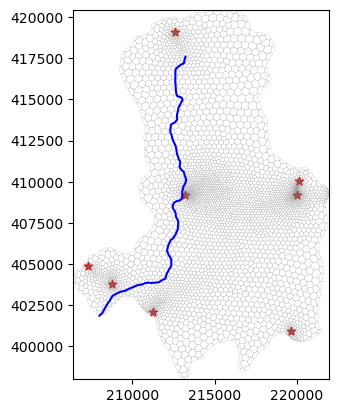

In [43]:
fig, ax = plt.subplots()
voronoi_grid.plot(ax=ax,lw=.1)
stream.plot(ax=ax, color='b')
ax.scatter(points['X'],points['Y'],marker='*',edgecolor='r')

# Grid intersection module

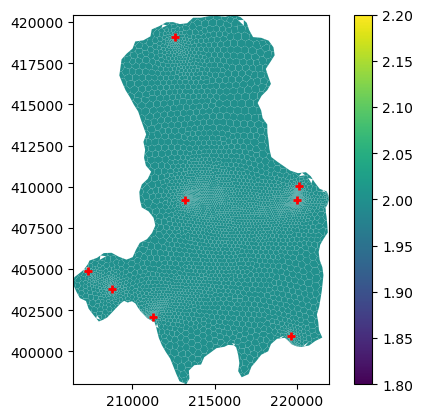

In [44]:
tic = datetime.datetime.now()
mi = ModelIntersect(vor)
idomain_vor = np.zeros((1,len(mi.polygon)), dtype=int)

if 1:
    drain = geopandas.read_file('./Noseong/Data/Stream_drained_arcs.shp')
    pos_drain_all = np.zeros(np.shape(mi.polygon), dtype=bool)
    for geo in drain.geometry:
        if geom is not None:
            pos_drain = mi.intersect(geom)
            pos_drain_all[pos_drain] = 1

    idomain_vor[0, np.where(pos_drain_all)] = 2

# Matplotlib gogo
fig, ax = plt.subplots()
pmv = flopy.plot.PlotMapView(modelgrid=voronoi_grid)
im = pmv.plot_array(idomain_vor)
fig.colorbar(im, ax=ax)
drain.plot(ax=ax, lw=2, color='b')

ax.scatter(points['X'], points['Y'], marker = '+', color='r', lw=2)

# Interpolate Top elevation using DEM

In [53]:
top = flopyUtils.interp.interpGeotiffToModel('./Noseong/Data/dem_studyarea.tif', voronoi_grid, verbose=0,)
print(f'   top size {np.shape(top)}')

ValueError: The points in dimension 1 must be strictly ascending

# Check the top elevation

NameError: name 'top' is not defined

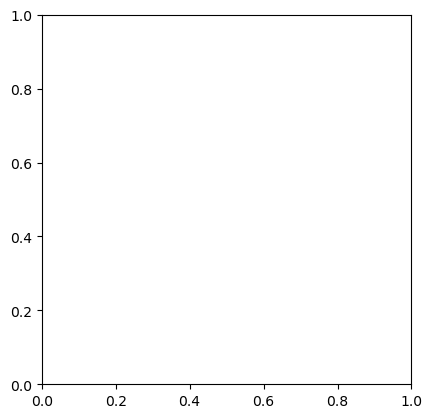

In [ ]:
fig, ax = plt.subplots()
pmv = flopy.plot.PlotMapView(modelgrid=voronoi_grid)
im = pmv.plot_array(top, cmap=cmcrameri.cm.batlow, vmin=5, vmax=750)
fig.colorbar(im, ax=ax, label = 'z(m)')
stream.plot(ax=ax, color='b', lw=2, label='stream')

ax.set_xticklabels(np.array(ax.get_xticks())/1000)
ax.set_yticklabels(np.array(ax.get_yticks())/1000)
ax.set_xlabel('x (km)')
ax.set_ylabel('y (km)')
ax.legend(loc='lower right')

print(f'   elevation')
print(f'   max {np.amax(top):.2f}')
print(f'   min {np.amin(top):.2f}')

# Formulate mf6 packages from these input data

In [ ]:
name = "mf"
model_ws = './Noseong/'
sim = flopy.mf6.MFSimulation(sim_name=name, version="mf6", exe_name="mf6", sim_ws=model_ws)
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", nper=1, perioddata=[[1, 1, 1.]],
   start_date_time='2023-01-01',)
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True,)
ims = flopy.mf6.ModflowIms(sim, print_option="SUMMARY", complexity="complex",linear_acceleration = "BICGSTAB",)
cell2d = vor.get_disv_gridprops()['cell2d']
vertices = vor.get_disv_gridprops()['vertices']
xy = np.array(vertices)
nlay=4
ncpl = vor.get_disv_gridprops()['ncpl']
nvert = vor.get_disv_gridprops()['nvert']
botm1 = top - 10 # uniform top layer
botm2 = np.linspace(botm1, 0, nlay)
botm = botm2
dis = flopy.mf6.ModflowGwfdisv(
    gwf,
    nlay=nlay,
    ncpl=ncpl,
    nvert=nvert,
    top=top,
    botm=botm,
    vertices=vor.get_disv_gridprops()['vertices'],
    cell2d=vor.get_disv_gridprops()['cell2d'],
    idomain=1,
)

# NPF package -> Node property information
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[(True)], save_specific_discharge=None,icelltype=1,k=1)
ic = flopy.mf6.ModflowGwfic(gwf, strt=500)

#Set recharge
rch_rate = 1.0e-5
flopy.mf6.ModflowGwfrcha(gwf, recharge=rch_rate)

#Set stream package
ns_stream = geopandas.read_file('./Noseong/Data/stream_1_arcs.shp')
pos_all = np.zeros(np.shape(mi.polygon), dtype=bool)
for geom in ns_stream.geometry:
   if geom is not None:
      pos = mi.intersect(geom)
      pos_all[pos] = 1
ns_stream_cells = np.where(pos_all)[0]

#Set drain
drain_tri = geopandas.read_file('./Noseong/Data/Stream_drained_arcs.shp')
pos_all = np.zeros(np.shape(mi.polygon), dtype=bool)
for geom in drain_tri.geometry:
   if geom is not None:
      pos = mi.intersect(geom)
      pos_all[pos] = 1
drain_tri_cells = np.where(pos_all)[0]

drn_spd    = []
drn_depth  = 1.0    # drainage depth (unit: meter)
drn_hk     = 10.0   # vertical hydraulic conductivity (unit: m/day)
drn_bed_thk= 0.5    # vertical drainage thickness (unit: meter)
for idx in drain_tri_cells:
   drn_spd.append([(0,idx), top[idx], drn_hk*areas[idx]/drn_bed_thk, -drn_depth])
   drn = flopy.mf6.ModflowGwfdrn(gwf,
            auxiliary=["depth"],
            auxdepthname="depth",
            stress_period_data={0:drn_spd})

# Set output file
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    budget_filerecord=f"{name}.cbc",
    head_filerecord=f"{name}.hds",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],)
if 1:
   sim.write_simulation(silent=1)
   success, buff = sim.run_simulation(report=True, silent=0)
   assert success
   print('done')

NameError: name 'top' is not defined